In [1]:
# All Imports
import sys 
import numpy as np
import json
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
#from sklearn.cluster import DBSCAN
import collections
#from sklearn.neighbors import NearestNeighbors
#from gensim.test.utils import common_texts
import pickle

from gensim.models.doc2vec import Doc2Vec #, TaggedDocument,KeyedVectors 
#from gensim.test.utils import get_tmpfile
import nltk
#from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

from sklearn.cluster import KMeans

In [9]:
nltk.download(["stopwords", "averaged_perceptron_tagger", "vader_lexicon"])

stopwords = nltk.corpus.stopwords.words("english")
stopwords.append(nltk.corpus.stopwords.words("spanish"))
stopwords.append(nltk.corpus.stopwords.words("german"))
stopwords.append(nltk.corpus.stopwords.words("dutch"))
stopwords.append(nltk.corpus.stopwords.words("french"))
stopwords.append(nltk.corpus.stopwords.words("italian"))
stopwords += ['back', 'caus', 'yeah','thing',
 'tri','still', 'onli', 'around', 'fall', 'need', 'life', 'us', 'tell', 'tri', 'right', 'look','mano',
 'away', 'stand', 'back', 'alway', 'bir', 'egal','sui','perro','esa','–','sotto',
 'give', 'realli', 'alright', 'think','got', 'keep', 'need', 'let','\x96','za','à',
 'said','could', 'say', 'find', 'see', 'long', 'make', 'aan','ab', 'guitarra',
 'tua','meu','aussi', 've','sangr','venir', 'valor', 'par','veo', 'vos', 'sul', 'sou']

[nltk_data] Downloading package stopwords to /home/lilli/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/lilli/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/lilli/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
test_documents_json = pickle.load( open( "counted_bows_test", "rb" ) ) #test_documents
print(len(test_documents_json))
train_documents_json = pickle.load( open( "counted_bows", "rb" ) ) #train_documents
print(len(train_documents_json))

10969
123984


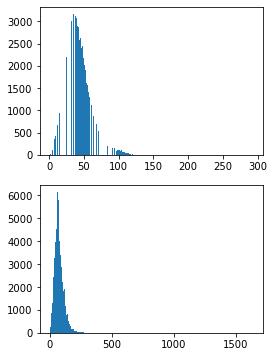

#Songs:  123984
#Unique Words:  3913
Longest Song:  293
Avg Wordcount:  41
Avg Unique Wordcount:  77


In [11]:
def plot_histograms(documents):
    amt_of_words = []
    amt_of_unique_words = []
    unique_words = []

    for track in documents:
        words = track[0]
        total_words = len(list(set(words)))
        amt_of_words.append(total_words)
        amt_of_unique_words.append(len(words))
        unique_words = set(list(unique_words) + words)
    fig, axs = plt.subplots(2,figsize=(4,6))
    axs[0].hist(amt_of_words, bins = 500)
    axs[1].hist(amt_of_unique_words, bins = 500)
    plt.show() 

    avg_amt_of_words = sum(amt_of_words) / len(amt_of_words)
    avg_amt_of_unique_words = sum(amt_of_unique_words) / len(amt_of_unique_words)
    print("#Songs: ", len(documents))
    print("#Unique Words: ", len(unique_words))
    print("Longest Song: ", max(amt_of_words))
    print("Avg Wordcount: ", int(avg_amt_of_words)  )
    print("Avg Unique Wordcount: ",int(avg_amt_of_unique_words))
    return unique_words  
        
        
uniqus= plot_histograms(docs)    

In [10]:
def remove_stopwords(doc_corpus):
    new_corp = []
    for doc in doc_corpus:
        words = [w for w in doc[0] if w.lower() not in stopwords]
        if len(words) == 0:
            print("removed")
        else:
            new_corp.append([words,doc[1]])
    return new_corp

docs = remove_stopwords(train_documents_json)
print(len(docs))

123984


In [35]:
def build_tfidf_df(documents):
    corpus = [' '.join(x[0]) for x in docs]
    vectorizer = TfidfVectorizer()
    tfidf_x = vectorizer.fit_transform(corpus)
    df_countvect = pd.DataFrame(data= tfidf_x.toarray(), index=[i[1][0] for i in docs], 
                                columns=vectorizer.get_feature_names() )
    with open("tfidf_df.p","wb") as tfidfp:
        pickle.dump(df_countvect, tfidfp)   

In [94]:
def train_model(documents):
    train_documents = [TaggedDocument(i[0],[i[1][0]]) for i in documents]
    modeld2v = Doc2Vec(documents=train_documents, vector_size=10, epochs=100, min_count=2, workers=6)
    modeld2v.save("stopwords_removed2.model")
    
    inferred_vectors = {}
    for doc_id in [i[1][0] for i in documents]:
        inferred_vector = model.dv[doc_id]
        inferred_vectors[doc_id] = inferred_vector
    with open("inferred_vectors_dict.p","wb") as inf_json:
        pickle.dump(inferred_vectors,inf_json)

In [34]:
def do_clustering(df, inferred):
    kmeans_model = KMeans(init='k-means++', n_clusters=20, n_init=10)
    kmeans_model.fit(np.array(list(inferred.values())))
    clustering = kmeans_model.labels_
    clust_df = pd.DataFrame({'cluster': clustering}, index=[i for i in inferred.keys()])
    new_df = df.join(clust_df)
    with open("tfidf_df.p","wb") as inf_json:
        pickle.dump(new_df,inf_json)
    return new_df

In [36]:
def add_genre_todf(df):
    test_dictionary = pickle.load( open( "test_dict.p", "rb" ) ) 
    genres = [i['index'] for i in test_dictionary.values()]
    clust_df = pd.DataFrame({'genre': genres}, index=[i for i in test_dictionary.keys()] )
    new_df = df.join(clust_df)
    new_df['genre'] = new_df['genre'].replace(np.nan, 7)
    new_df['genre'] = pd.to_numeric(new_df['genre'], downcast='signed')

    return new_df

In [121]:
def sentiment_analyzer(documents):
    sia = SentimentIntensityAnalyzer()
    polarity_scores = {}
    for doc in documents:
        polarity_scores[doc[1][0]] = sia.polarity_scores(' '.join(set(doc[0])))
    return polarity_scores


sia_scores = sentiment_analyzer(docs)
with open("sia_scores","wb") as test_json:
    pickle.dump(sia_scores,test_json)
test_json.close()

In [2]:
def compute_test_with_topwords(X_embedded= None, df_countvect=None, new_clustering=False, new_tsne=False):
    # load data
    # vectors from doc2vec model doc_id: [vector]
    test_dictionary = pickle.load( open( "test_dict.p", "rb" ) )
    sia_scores = pickle.load( open( "sia_scores.p", "rb" ) ) 
    test_sias = {x:sia_scores[x] for x in test_dictionary.keys()}
    # tf-idf matrix: doc_id w1 w2 ... wn
    if df_countvect is None:
        df_countvect = pickle.load( open( "tfidf_df.p", "rb" ) )
    genre_labels = {i['index']:i['name'] for i in test_dictionary.values()}

    # np array of sia scores
    X_sia = np.array([list(test_sias[i].values()) for i in test_sias.keys()])

    # np array of vectors
    X = np.array([i['vector'] for i in test_dictionary.values()])
    
    # apply t-SNE
    if new_tsne or X_embedded is None:
        X_embedded = TSNE(n_components=2, perplexity=100, learning_rate=200).fit_transform(X)
        X_embedded.shape
    
    tfidf_vecs = [] #df_countvect.loc(0)[list(test_dictionary.keys())]
    clustering = [] #list(tfidf_vecs['cluster'].to_numpy())
    if new_clustering:
        # cluster
        all_inferred = pickle.load( open( "inferred_vectors_dict.p", "rb" ) )
        df_countvect = do_clustering(df_countvect, all_inferred)
        tfidf_vecs = df_countvect.loc(0)[list(test_dictionary.keys())]
        clustering = list(tfidf_vecs['cluster'].to_numpy())
        print(set(clustering))
    else:
        tfidf_vecs = df_countvect.loc(0)[list(test_dictionary.keys())]
        clustering = list(tfidf_vecs['cluster'].to_numpy())   

    cluster_labels = []
    for i in range(20):
        cluster = df_countvect.loc(0)[df_countvect.loc(1)['cluster'] == i]
        cluster_mean = cluster.mean()
        top_words = cluster_mean.sort_values()
        cluster_labels.append(top_words[-30:-20])
        
    genre_topwords = []
    for i in range(20):
        gcluster = df_countvect.loc(0)[df_countvect.loc(1)['genre'] == i]
        gcluster_mean = gcluster.mean()
        gtop_words = gcluster_mean.sort_values()
        genre_topwords.append(gtop_words[-30:-20])
    genre_lab = [genre_labels[i] +': '+ ' , '.join(list(genre_topwords[i].keys().to_numpy())) for i in range(20)]
        
    return X_embedded, clustering, cluster_labels, genre_lab, test_dictionary, genre_topwords, X_sia

In [3]:
tsne,clusters,c_labels,genres,dict_test, gen_tw, sia_embed = compute_test_with_topwords(
    X_embedded=None, df_countvect=None,new_clustering=False, new_tsne=False) 

In [4]:
colors = ['#e6194b', '#3cb44b', '#ffe119','#ffd8b1', '#aaffc3', '#fffac8', '#808080', 
          '#4363d8', '#f58231', '#911eb4', 
          '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', '#808000', 
          '#9a6324', '#000075', '#800000',  ]


def draw_scatter(data, cs, n_clust=20):
    plt.figure(figsize=(25, 25))
    plt.scatter([i[0] for i in data],[i[1] for i in data], color=[colors[i] for i in cs], s=30)
    
def draw_legend(labels, n_clust=20):
    plt.figure(figsize=(20, 10))
    plt.scatter([-10 for i in range(n_clust)],[i*3 for i in range(n_clust)], color=[colors[i] for i in list(range(0,n_clust))], cmap='tab20', s=200, marker="s")
    plt.scatter([0],[0],c=[0], cmap='tab20', s=5, marker="s")
    for i in list(range(0,n_clust)):
        txt = labels[i] if isinstance(labels[i], str) else ', '.join(list(labels[i].keys().to_numpy()))
        plt.annotate(txt, (-9.8,  i*3),fontsize=24, va='center')


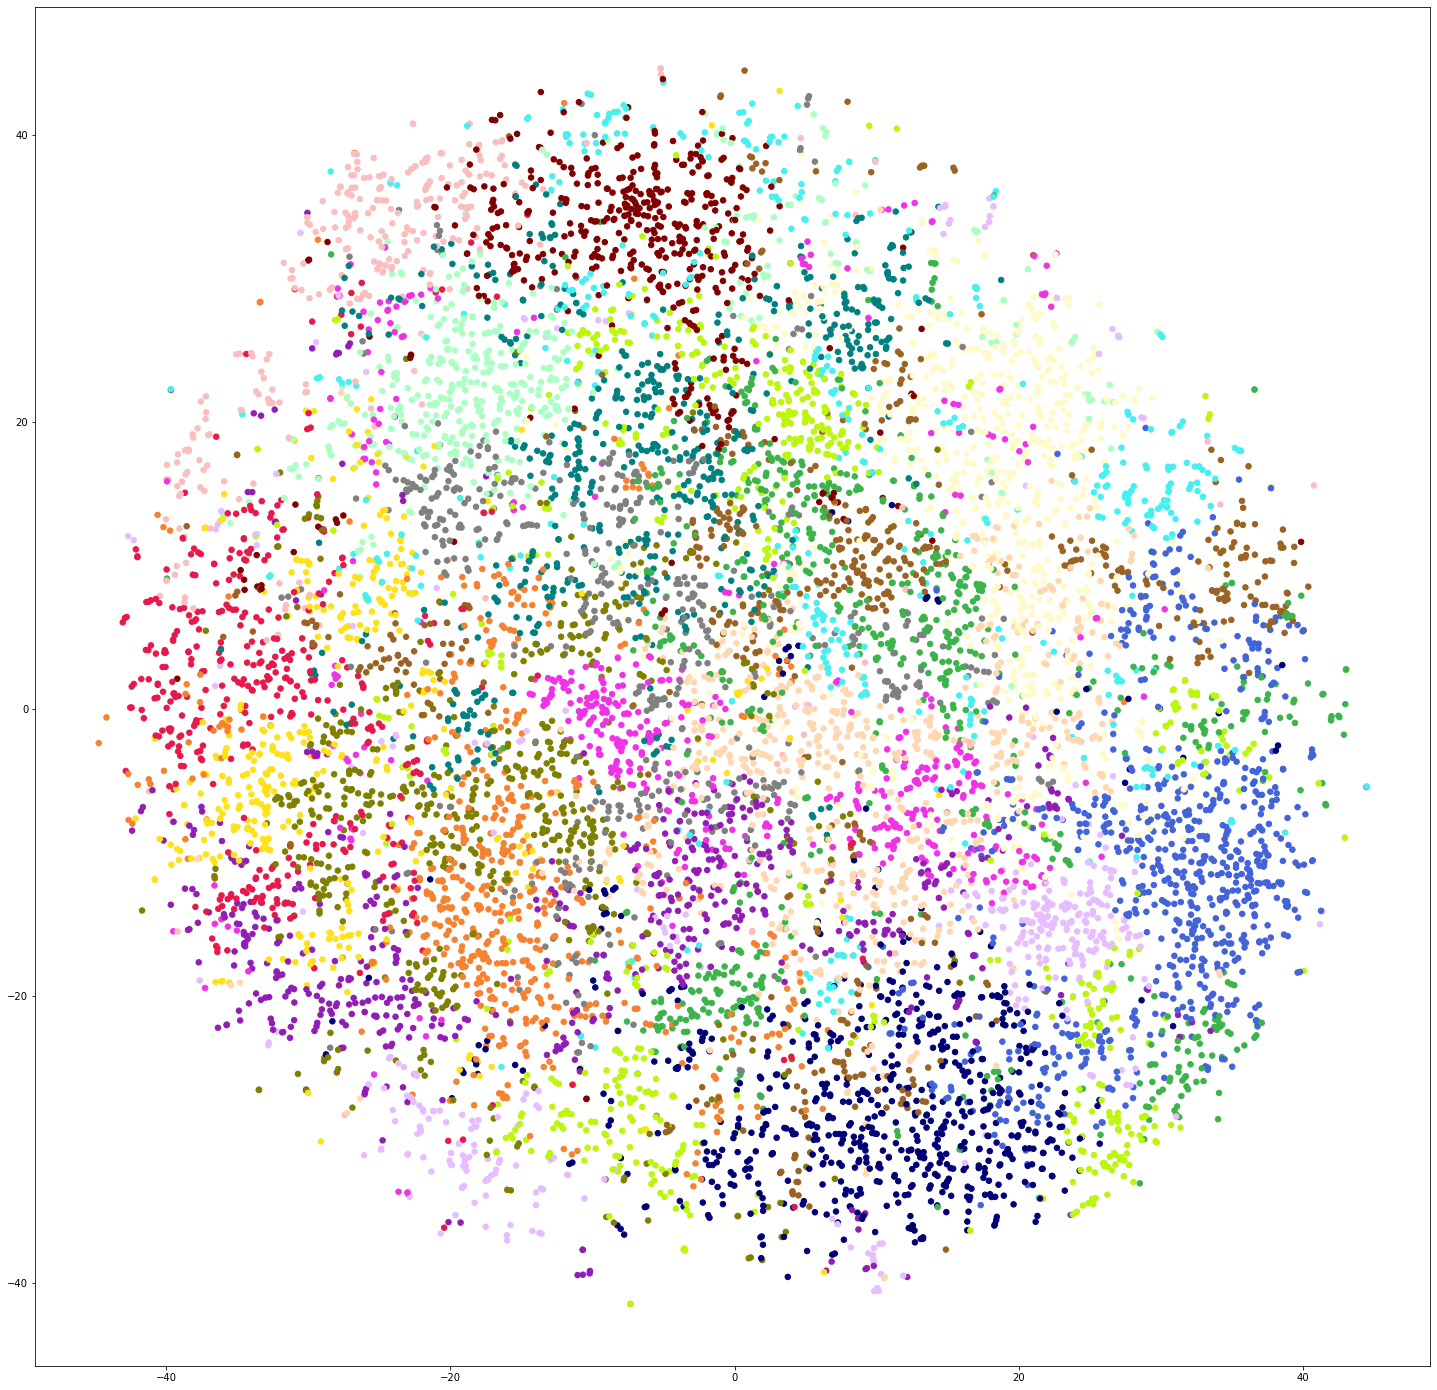

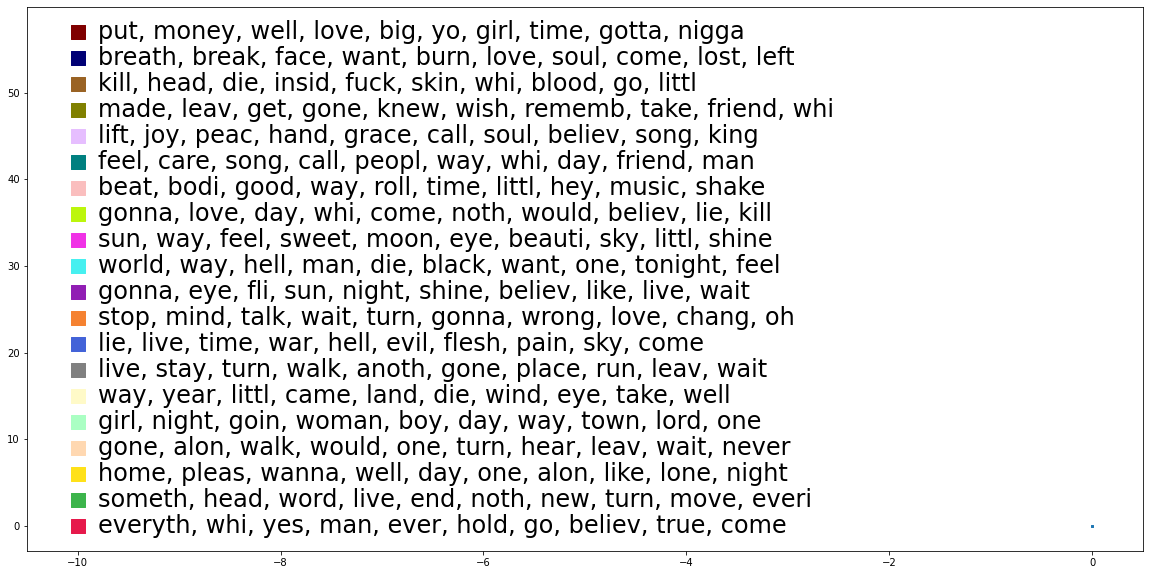

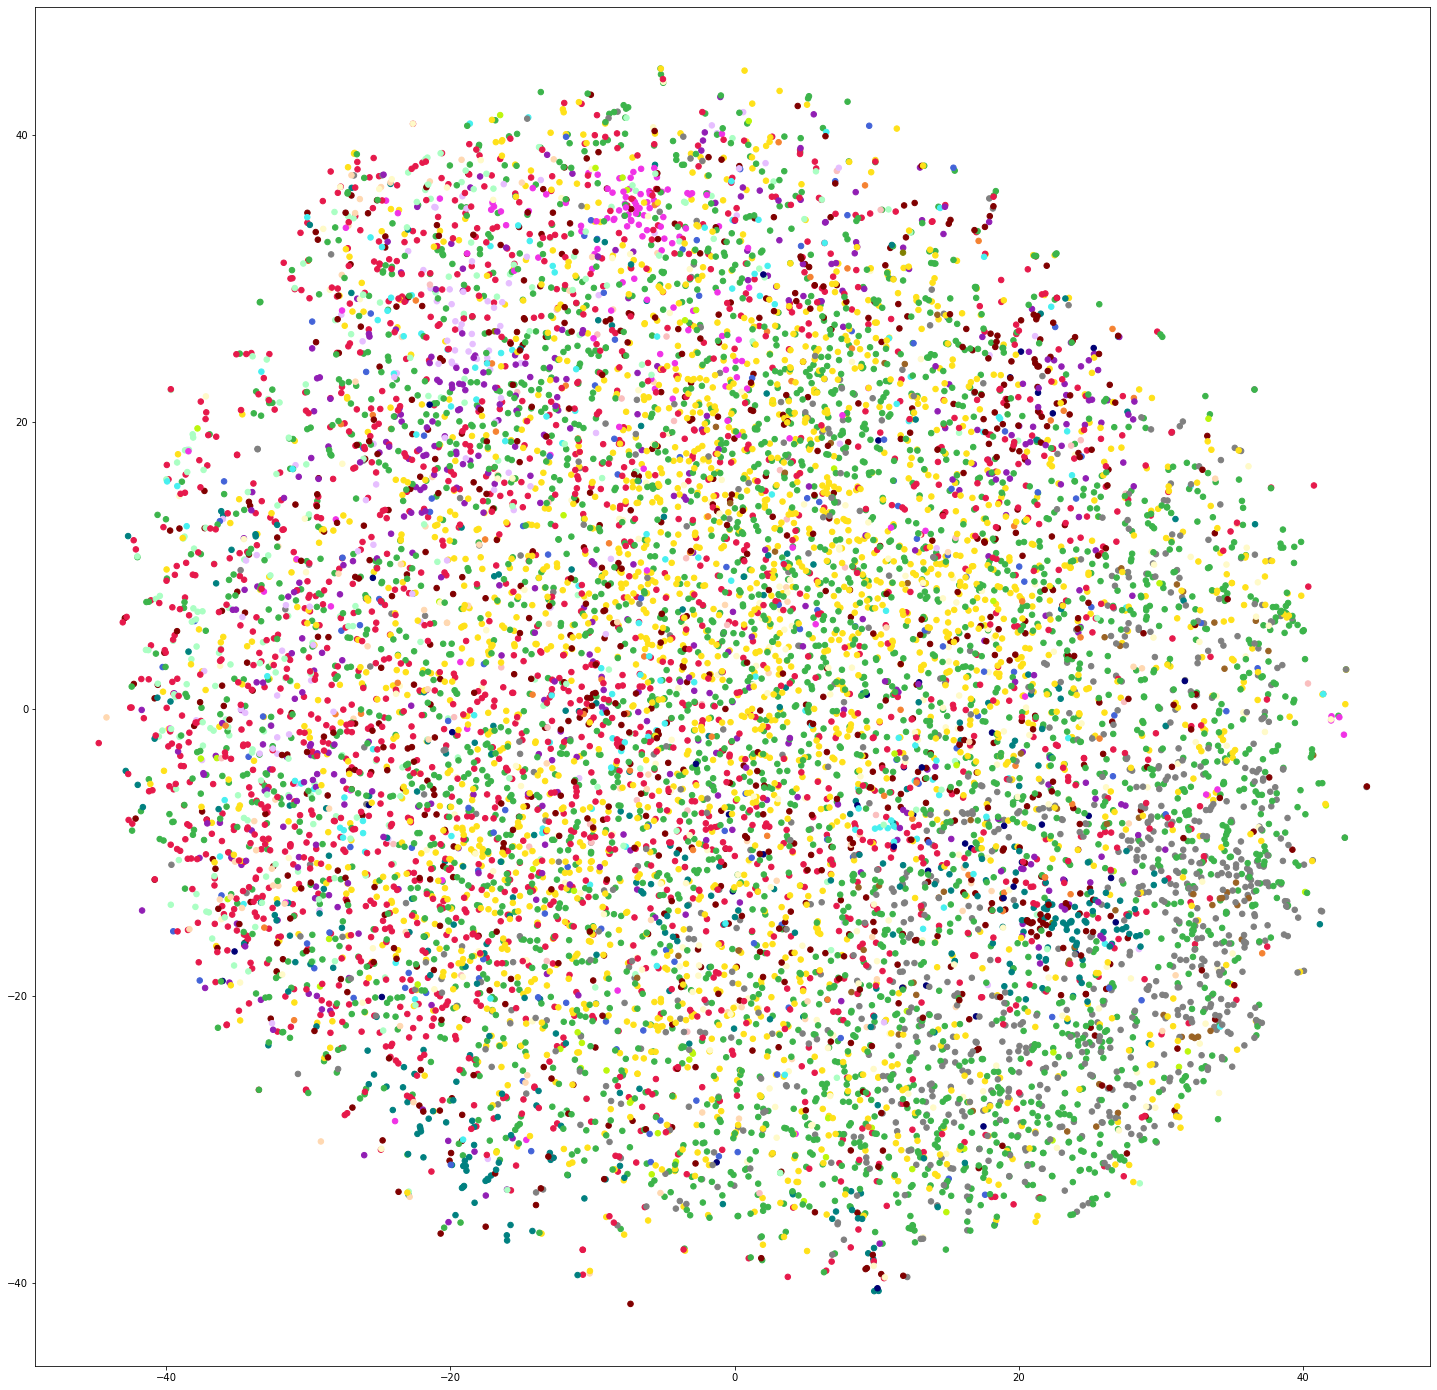

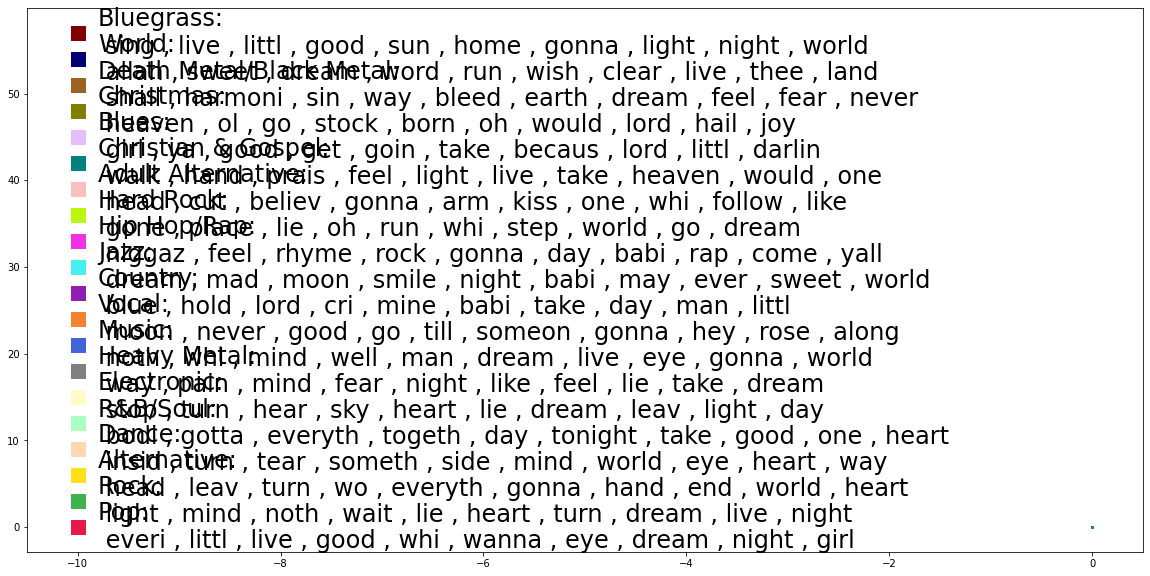

In [6]:
draw_scatter(tsne, clusters)
draw_legend(c_labels)
draw_scatter(tsne, [i['index'] for i in dict_test.values()])
draw_legend(genres)